## Workload detection algorithm

Neural network that takes as input the image of the screen and predicts the type of workload from the following categories.
* browsing
* coding
* idle
* office
* entertainment


In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# paths
train_dir = 'train'
test_dir = 'test'

2022-07-13 23:26:31.835725: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# Load data
BATCH_SIZE=32
IMG_SIZE= (160,160)

train_set = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
test_set = tf.keras.utils.image_dataset_from_directory(test_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 62 files belonging to 4 classes.
Found 1 files belonging to 4 classes.


2022-07-13 23:26:33.217133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 23:26:33.243573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 23:26:33.243902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 23:26:33.244632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [4]:
train_set.class_names

['browsing', 'coding', 'idle', 'office']

2022-07-13 23:26:33.790475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


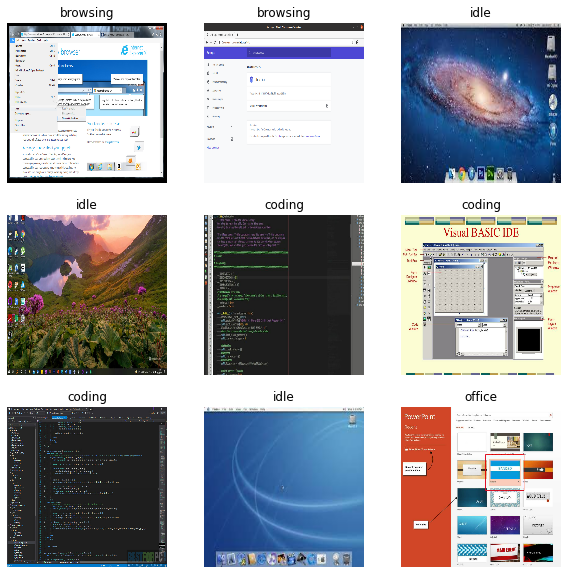

In [5]:
class_names = train_set.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

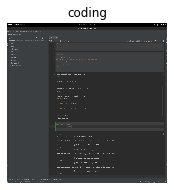

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in test_set.take(1):
    for i in range(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

In [8]:
# rescaling
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [9]:
# base model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [10]:
# pooling & classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(train_set.class_names))


In [11]:
# full model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)



In [12]:
# compile model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [13]:
history = model.fit(train_set,
                    epochs=100)


Epoch 1/100


2022-07-13 23:26:36.535970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:37.067210: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


2/2 [==============================] - 3s 417ms/step - loss: 2.2140 - accuracy: 0.1935
Epoch 2/100
2/2 [==============================] - 0s 41ms/step - loss: 1.9316 - accuracy: 0.1774
Epoch 3/100


2022-07-13 23:26:38.373359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 48ms/step - loss: 1.8852 - accuracy: 0.2258
Epoch 4/100


2022-07-13 23:26:38.607132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 46ms/step - loss: 1.8673 - accuracy: 0.2258
Epoch 5/100


2022-07-13 23:26:38.821203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:38.998066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 32ms/step - loss: 1.8734 - accuracy: 0.1774
Epoch 6/100
2/2 [==============================] - 0s 47ms/step - loss: 1.9060 - accuracy: 0.2097
Epoch 7/100


2022-07-13 23:26:39.173713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 38ms/step - loss: 1.5870 - accuracy: 0.2903
Epoch 8/100


2022-07-13 23:26:39.405459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:39.601956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 47ms/step - loss: 1.8040 - accuracy: 0.1935
Epoch 9/100
2/2 [==============================] - 0s 44ms/step - loss: 1.7321 - accuracy: 0.1935
Epoch 10/100


2022-07-13 23:26:39.777680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 39ms/step - loss: 1.5592 - accuracy: 0.2742
Epoch 11/100


2022-07-13 23:26:40.010459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:40.180873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 40ms/step - loss: 1.4874 - accuracy: 0.3871
Epoch 12/100
2/2 [==============================] - 0s 49ms/step - loss: 1.5510 - accuracy: 0.4516
Epoch 13/100


2022-07-13 23:26:40.351484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 56ms/step - loss: 1.6286 - accuracy: 0.2258
Epoch 14/100


2022-07-13 23:26:40.582436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 49ms/step - loss: 1.4360 - accuracy: 0.3387
Epoch 15/100


2022-07-13 23:26:40.803557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 34ms/step - loss: 1.4238 - accuracy: 0.3548
Epoch 16/100


2022-07-13 23:26:41.010073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 33ms/step - loss: 1.5259 - accuracy: 0.3710
Epoch 17/100


2022-07-13 23:26:41.218212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:41.392226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 35ms/step - loss: 1.3263 - accuracy: 0.4677
Epoch 18/100
2/2 [==============================] - 0s 50ms/step - loss: 1.3647 - accuracy: 0.3710
Epoch 19/100


2022-07-13 23:26:41.581804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 47ms/step - loss: 1.4569 - accuracy: 0.3871
Epoch 20/100


2022-07-13 23:26:41.830427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 48ms/step - loss: 1.3887 - accuracy: 0.4032
Epoch 21/100


2022-07-13 23:26:42.070294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 46ms/step - loss: 1.3256 - accuracy: 0.5323
Epoch 22/100


2022-07-13 23:26:42.309365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 48ms/step - loss: 1.4298 - accuracy: 0.4355
Epoch 23/100


2022-07-13 23:26:42.553647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 48ms/step - loss: 1.3381 - accuracy: 0.4355
Epoch 24/100


2022-07-13 23:26:42.799387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 39ms/step - loss: 1.3874 - accuracy: 0.3710
Epoch 25/100


2022-07-13 23:26:43.037158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:43.209358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 37ms/step - loss: 1.3125 - accuracy: 0.5161
Epoch 26/100
2/2 [==============================] - 0s 36ms/step - loss: 1.2674 - accuracy: 0.4677
Epoch 27/100


2022-07-13 23:26:43.387241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:43.578652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 48ms/step - loss: 1.1619 - accuracy: 0.5645
Epoch 28/100
2/2 [==============================] - 0s 53ms/step - loss: 1.1880 - accuracy: 0.4355
Epoch 29/100


2022-07-13 23:26:43.809336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:43.996777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 38ms/step - loss: 1.2219 - accuracy: 0.5323
Epoch 30/100
2/2 [==============================] - 0s 41ms/step - loss: 1.2782 - accuracy: 0.5000
Epoch 31/100


2022-07-13 23:26:44.191349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:44.381824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 40ms/step - loss: 1.2688 - accuracy: 0.4516
Epoch 32/100
2/2 [==============================] - 0s 42ms/step - loss: 1.0252 - accuracy: 0.5968
Epoch 33/100


2022-07-13 23:26:44.622603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 44ms/step - loss: 1.2073 - accuracy: 0.4194
Epoch 34/100


2022-07-13 23:26:44.858811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 34ms/step - loss: 1.2214 - accuracy: 0.5161
Epoch 35/100


2022-07-13 23:26:45.075425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:45.245273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 39ms/step - loss: 1.0386 - accuracy: 0.5323
Epoch 36/100
2/2 [==============================] - 0s 59ms/step - loss: 1.0452 - accuracy: 0.5323
Epoch 37/100


2022-07-13 23:26:45.439484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 49ms/step - loss: 1.1110 - accuracy: 0.5161
Epoch 38/100


2022-07-13 23:26:45.697379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:45.875230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 44ms/step - loss: 1.1924 - accuracy: 0.5323
Epoch 39/100
2/2 [==============================] - 0s 44ms/step - loss: 1.1410 - accuracy: 0.4677
Epoch 40/100


2022-07-13 23:26:46.115127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 37ms/step - loss: 1.0927 - accuracy: 0.5323
Epoch 41/100


2022-07-13 23:26:46.333525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 33ms/step - loss: 1.0599 - accuracy: 0.5806
Epoch 42/100


2022-07-13 23:26:46.563668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:46.741446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 32ms/step - loss: 1.0901 - accuracy: 0.5806
Epoch 43/100
2/2 [==============================] - 0s 36ms/step - loss: 1.0215 - accuracy: 0.5968
Epoch 44/100


2022-07-13 23:26:46.909622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:47.108208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 47ms/step - loss: 0.9236 - accuracy: 0.6613
Epoch 45/100
2/2 [==============================] - 0s 45ms/step - loss: 0.9430 - accuracy: 0.5645
Epoch 46/100


2022-07-13 23:26:47.354919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 44ms/step - loss: 0.9250 - accuracy: 0.6452
Epoch 47/100


2022-07-13 23:26:47.563594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 48ms/step - loss: 0.9605 - accuracy: 0.5968
Epoch 48/100


2022-07-13 23:26:47.788278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 47ms/step - loss: 0.9134 - accuracy: 0.6935
Epoch 49/100


2022-07-13 23:26:48.016538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 45ms/step - loss: 0.9333 - accuracy: 0.6290
Epoch 50/100


2022-07-13 23:26:48.222874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 33ms/step - loss: 1.1074 - accuracy: 0.4839
Epoch 51/100


2022-07-13 23:26:48.441100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:48.615240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 39ms/step - loss: 1.0018 - accuracy: 0.5645
Epoch 52/100
2/2 [==============================] - 0s 43ms/step - loss: 0.8401 - accuracy: 0.6290
Epoch 53/100


2022-07-13 23:26:48.799140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 57ms/step - loss: 0.8960 - accuracy: 0.7097
Epoch 54/100


2022-07-13 23:26:49.031000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:49.224969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 40ms/step - loss: 0.8201 - accuracy: 0.6290
Epoch 55/100
2/2 [==============================] - 0s 33ms/step - loss: 0.9031 - accuracy: 0.6613
Epoch 56/100


2022-07-13 23:26:49.403582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:49.581409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 33ms/step - loss: 0.8234 - accuracy: 0.6613
Epoch 57/100
2/2 [==============================] - 0s 48ms/step - loss: 0.8935 - accuracy: 0.6452
Epoch 58/100


2022-07-13 23:26:49.800261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 48ms/step - loss: 0.8635 - accuracy: 0.6452
Epoch 59/100


2022-07-13 23:26:50.031958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 48ms/step - loss: 0.9822 - accuracy: 0.5806
Epoch 60/100


2022-07-13 23:26:50.268532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 47ms/step - loss: 0.9311 - accuracy: 0.6452
Epoch 61/100


2022-07-13 23:26:50.475125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 33ms/step - loss: 0.8825 - accuracy: 0.6129
Epoch 62/100


2022-07-13 23:26:50.711912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:50.903275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 36ms/step - loss: 0.8146 - accuracy: 0.7258
Epoch 63/100
2/2 [==============================] - 0s 47ms/step - loss: 0.8568 - accuracy: 0.6935
Epoch 64/100


2022-07-13 23:26:51.135073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 47ms/step - loss: 0.7498 - accuracy: 0.6774
Epoch 65/100


2022-07-13 23:26:51.371498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 47ms/step - loss: 0.7555 - accuracy: 0.7258
Epoch 66/100


2022-07-13 23:26:51.617198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:51.794599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 34ms/step - loss: 0.8351 - accuracy: 0.6613
Epoch 67/100
2/2 [==============================] - 0s 34ms/step - loss: 0.7649 - accuracy: 0.7258
Epoch 68/100


2022-07-13 23:26:51.966783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:52.140576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 37ms/step - loss: 0.7308 - accuracy: 0.7419
Epoch 69/100
2/2 [==============================] - 0s 44ms/step - loss: 0.7889 - accuracy: 0.6935
Epoch 70/100


2022-07-13 23:26:52.324402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:52.515982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 34ms/step - loss: 0.6531 - accuracy: 0.7903
Epoch 71/100
2/2 [==============================] - 0s 71ms/step - loss: 0.7253 - accuracy: 0.7258
Epoch 72/100


2022-07-13 23:26:52.688840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 33ms/step - loss: 0.8160 - accuracy: 0.6935
Epoch 73/100


2022-07-13 23:26:52.946771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:53.124400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 46ms/step - loss: 0.7627 - accuracy: 0.6774
Epoch 74/100
2/2 [==============================] - 0s 46ms/step - loss: 0.7129 - accuracy: 0.7903
Epoch 75/100


2022-07-13 23:26:53.346956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 43ms/step - loss: 0.7017 - accuracy: 0.7581
Epoch 76/100


2022-07-13 23:26:53.552006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:53.731363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 43ms/step - loss: 0.7969 - accuracy: 0.7097
Epoch 77/100
2/2 [==============================] - 0s 50ms/step - loss: 0.7166 - accuracy: 0.7419
Epoch 78/100


2022-07-13 23:26:53.961066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 33ms/step - loss: 0.6915 - accuracy: 0.6935
Epoch 79/100


2022-07-13 23:26:54.201756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:54.369156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 41ms/step - loss: 0.7727 - accuracy: 0.6613
Epoch 80/100
2/2 [==============================] - 0s 34ms/step - loss: 0.6440 - accuracy: 0.7742
Epoch 81/100


2022-07-13 23:26:54.565368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 42ms/step - loss: 0.7674 - accuracy: 0.6774
Epoch 82/100


2022-07-13 23:26:54.776140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:54.968064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 43ms/step - loss: 0.7901 - accuracy: 0.6290
Epoch 83/100
2/2 [==============================] - 0s 34ms/step - loss: 0.5975 - accuracy: 0.8065
Epoch 84/100


2022-07-13 23:26:55.207668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:55.376241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 41ms/step - loss: 0.6709 - accuracy: 0.7258
Epoch 85/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6044 - accuracy: 0.8065
Epoch 86/100


2022-07-13 23:26:55.553890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 42ms/step - loss: 0.6855 - accuracy: 0.7258
Epoch 87/100


2022-07-13 23:26:55.782550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:55.982577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 48ms/step - loss: 0.6170 - accuracy: 0.8065
Epoch 88/100
2/2 [==============================] - 0s 60ms/step - loss: 0.5853 - accuracy: 0.8226
Epoch 89/100


2022-07-13 23:26:56.244443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:56.444107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 33ms/step - loss: 0.6365 - accuracy: 0.7419
Epoch 90/100
2/2 [==============================] - 0s 43ms/step - loss: 0.6821 - accuracy: 0.7419
Epoch 91/100


2022-07-13 23:26:56.626638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:56.802843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 33ms/step - loss: 0.6396 - accuracy: 0.7097
Epoch 92/100
2/2 [==============================] - 0s 34ms/step - loss: 0.5862 - accuracy: 0.8065
Epoch 93/100


2022-07-13 23:26:56.965629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 49ms/step - loss: 0.6539 - accuracy: 0.6774
Epoch 94/100


2022-07-13 23:26:57.189709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 35ms/step - loss: 0.5970 - accuracy: 0.7903
Epoch 95/100


2022-07-13 23:26:57.411162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:57.589065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 33ms/step - loss: 0.5959 - accuracy: 0.8226
Epoch 96/100
2/2 [==============================] - 0s 33ms/step - loss: 0.6000 - accuracy: 0.8065
Epoch 97/100


2022-07-13 23:26:57.758435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 41ms/step - loss: 0.5750 - accuracy: 0.8065
Epoch 98/100


2022-07-13 23:26:57.962576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 35ms/step - loss: 0.7309 - accuracy: 0.7419
Epoch 99/100


2022-07-13 23:26:58.174009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-07-13 23:26:58.366191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 0s 44ms/step - loss: 0.6839 - accuracy: 0.7097
Epoch 100/100
2/2 [==============================] - 0s 48ms/step - loss: 0.6051 - accuracy: 0.7419


2022-07-13 23:26:58.587535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [14]:
model.evaluate(test_set)

1/1 [==============================] - 1s 766ms/step - loss: 0.3760 - accuracy: 1.0000


[0.37599197030067444, 1.0]

In [15]:
model.predict(test_set.take(1))

1/1 [==============================] - 0s 370ms/step


array([[-0.34504315,  1.2582273 , -1.5122346 , -0.38909373]],
      dtype=float32)

In [16]:
tf.saved_model.save(model, "models")
label_map_path = os.path.join("models", "label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(train_set.class_names):
    pbtxt_content = (
            pbtxt_content
            + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)

with open('models/label_map.txt', 'w') as f:
    for i, class_name in enumerate(train_set.class_names):
        f.write(class_name + '\n')

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
